In [1]:
from __future__ import print_function, division
import os

import torch
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage import io, transform
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET
from copy import deepcopy
import random

from moviepy.editor import VideoFileClip,ImageSequenceClip
from IPython.display import HTML
import matplotlib.image as mpimg

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import cv2
from matplotlib import gridspec

import pickle
from pylab import *
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
cdict = {'red': ((0.0, 1.0, 1.0),
                 (0.125, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5625, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5625, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 0.0, 0.0),
                  (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

%matplotlib inline
# %matplotlib notebook

In [2]:
use_history = False
weights_file_name = 'CNN_weather_only'

# use_history = True
# weights_file_name = 'CNN_weather_and_history'

In [3]:
# loss_log = pickle.load(open('loss_log_'+weights_file_name+'_.p','rb'))
# # plt.plot(loss_log['val'])
# print('MSE = {0:.4f}'.format(np.nanmin(loss_log['val'])))

In [4]:
class CNN_SpeedPrediction_database(Dataset):
    def __init__(self, Traffic, Weather, data, transform=None, look_back = 6):

        self.Traffic = Traffic
        self.Weather = Weather
        self.data = data
        self.transform = transform
        self.look_back = look_back
#         printdb_trans_1 = Dataset_NVIDIA_1(annotation_list,frame_list,transform = PerspectiveTransform(MAP_FILE, world_origin, pixel_ratio, PMAT_FILE))(self.__len__())
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        assert idx < self.__len__(),'idx out of dataset index boundary'
        Traffic_today = self.Traffic[idx,:,:,:]
        Weather_today = self.Weather[idx,:,:,:]
        Traffic_history = 0 
        Traffic_output = self.Traffic[idx,:,:,0]
        
        dayofweek = self.data.loc[idx]['dayofweek']
        data_sub = self.data[:idx]
        sameday_in_history = data_sub.index[data_sub['dayofweek'] == dayofweek].tolist()
        
#         Traffic_history = np.full((self.look_back,)+self.Traffic.shape[1:], np.nan)
        
        Traffic_history = [self.Traffic[idx,:,:,:]+np.random.randn(15,1440,3) for _ in range(self.look_back)]
        Traffic_history = np.stack(Traffic_history,0)
        
#         print(len(sameday_in_history))
        sameday_in_near_history = sameday_in_history[-self.look_back:]
#         print(len(sameday_in_near_history))
        
        for i in range(len(sameday_in_near_history)):
            Traffic_history[self.look_back-len(sameday_in_near_history)+i] = self.Traffic[sameday_in_near_history[i]]
        
        sample = {'weather': torch.Tensor(Weather_today), 'history': torch.Tensor(Traffic_history), 'label': torch.Tensor(Traffic_output)} # 

        if self.transform:
            sample = self.transform(sample)
        return sample
    
class CNN_SpeedPrediction_patch_database(Dataset):
    def __init__(self, Traffic, Weather, data, transform=None, look_back = 6, patch_length = 120, stride = 10):
        '''
        patch_length = 120 minutes =2 hrs
        stride = 10 minutes 
        '''

        self.Traffic = Traffic
        self.Weather = Weather
        self.data = data
        self.transform = transform
        self.look_back = look_back
        self.patch_length = patch_length
        self.stride = stride
        self.rate = (1440-patch_length)/stride+1
#         printdb_trans_1 = Dataset_NVIDIA_1(annotation_list,frame_list,transform = PerspectiveTransform(MAP_FILE, world_origin, pixel_ratio, PMAT_FILE))(self.__len__())
    def __len__(self):
        return int(len(self.data)*self.rate)

    def __getitem__(self, idx):
        
        assert idx < self.__len__(),'idx out of dataset index boundary'
        
        day_idx = int(idx/self.rate)
        hr_idx = int(idx%self.rate)
        Traffic_today = self.Traffic[day_idx,:,hr_idx*self.stride:hr_idx*self.stride+self.patch_length,:]
        Weather_today = self.Weather[day_idx,:,hr_idx*self.stride:hr_idx*self.stride+self.patch_length,:]
        Traffic_history = 0 
        Traffic_output = self.Traffic[day_idx,:,hr_idx*self.stride:hr_idx*self.stride+self.patch_length,0]
        
        dayofweek = self.data.loc[day_idx]['dayofweek']
        data_sub = self.data[:day_idx]
        sameday_in_history = data_sub.index[data_sub['dayofweek'] == dayofweek].tolist()
        
#         Traffic_history = np.full((self.look_back,)+self.Traffic.shape[1:], np.nan)
        
        Traffic_history = [self.Traffic[day_idx,:,hr_idx*self.stride:(hr_idx*self.stride+self.patch_length),:]+np.random.randn(15,self.patch_length,3) for _ in range(self.look_back)]
        Traffic_history = np.stack(Traffic_history,0)
#         print(len(sameday_in_history))
        sameday_in_near_history = sameday_in_history[-self.look_back:]
#         print(len(sameday_in_near_history))
        
        for i in range(len(sameday_in_near_history)):
            Traffic_history[self.look_back-len(sameday_in_near_history)+i] = self.Traffic[sameday_in_near_history[i],:,hr_idx*self.stride:hr_idx*self.stride+self.patch_length,:]
        
        sample = {'weather': torch.Tensor(Weather_today), 'history': torch.Tensor(Traffic_history), 'label': torch.Tensor(Traffic_output)} # 

        if self.transform:
            sample = self.transform(sample)
        return sample

In [5]:
''''''
which_data = 'Data_2015_DES_I235E'
(Traffic_2015,Weather_2015,data_2015) = pickle.load( open(which_data+"_filter_smooth.p", "rb" ) )
year =  data_2015['y'][0][:4]
print('{} data loaded'.format(year))

which_data = 'Data_2016_DES_I235E'
(Traffic_2016,Weather_2016,data_2016) = pickle.load( open(which_data+"_filter_smooth.p", "rb" ) )
year =  data_2016['y'][0][:4]
print('{} data loaded'.format(year))

data = pd.concat([data_2015,data_2016],ignore_index=True)
Traffic = np.concatenate([Traffic_2015, Traffic_2016],axis = 0)
Weather_5min = np.concatenate([Weather_2015, Weather_2016],axis = 0)
Weather = np.zeros([Weather_5min.shape[0],Weather_5min.shape[1],Weather_5min.shape[2]*5,Weather_5min.shape[3]])
for i in range(Weather.shape[2]):
    Weather[:,:,i,:] = Weather_5min[:,:,int(i/5),:]
Weather = np.delete(Weather,1,axis=3)


db = CNN_SpeedPrediction_database(Traffic, Weather, data)
# db = CNN_SpeedPrediction_patch_database(Traffic, Weather, data)
print('database "db" built from file')

Traffic_max = []
Traffic_min = []
Weather_max = []
Weather_min = []

for i in range(Traffic.shape[-1]):
    Traffic_max.append(np.max(Traffic[:,:,:,i]))
    Traffic_min.append(np.min(Traffic[:,:,:,i]))
for i in range(Weather.shape[-1]):
    Weather_max.append(np.max(Weather[:,:,:,i]))
    Weather_min.append(np.min(Weather[:,:,:,i]))
    
Min_Max = (Traffic_max,Traffic_min,Weather_max,Weather_min)

# loss_log = pickle.load( open('loss_log_'+weights_file_name+'_.p', "rb" ) )
# print('training log loaded into loss_log')
''''''

2015 data loaded
2016 data loaded
database "db" built from file


''

In [6]:
class CNN_Long_Term_Speed_Pred_Net(nn.Module):
    def __init__(self, use_gpu = True, use_history = True, Min_Max = Min_Max):
        super(CNN_Long_Term_Speed_Pred_Net, self).__init__()
        
        self.use_gpu = use_gpu
        self.use_history = use_history

        '''for on-fly normalization'''
        self.Traffic_max = Min_Max[0]
        self.Traffic_min = Min_Max[1]
        self.Weather_max = Min_Max[2]
        self.Weather_min = Min_Max[3]
        
        self.weather_layer1_conv2d = nn.Sequential(nn.Conv2d(in_channels=9, out_channels=2, kernel_size=(1,1)),nn.BatchNorm2d(2),nn.ReLU())
        self.weather_layer2_conv2d = nn.Sequential(nn.Conv2d(in_channels=2, out_channels=2, kernel_size=(3,3)),nn.BatchNorm2d(2),nn.ReLU())
        self.weather_layer3_conv2d = nn.Sequential(nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(3,3)),nn.BatchNorm2d(3),nn.ReLU())
        
        self.history_layer1_conv3d = nn.Conv3d(in_channels=1, out_channels=2, kernel_size=(3,3,3))
        self.history_layer2_conv2d = nn.Sequential(nn.BatchNorm2d(8),nn.ReLU(),nn.Conv2d(in_channels=8, out_channels=2, kernel_size=(1,1)),nn.BatchNorm2d(2),nn.ReLU())
        self.history_layer3_conv2d = nn.Sequential(nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(3,3)),nn.BatchNorm2d(3),nn.ReLU())
        
        self.decoder_layer1_conv2d = nn.Sequential(nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=(3,3)),nn.BatchNorm2d(1),nn.ReLU())
        self.decoder_layer2_conv2d = nn.Sequential(nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(3,3)),nn.Sigmoid())

    def forward(self, input_sample, future = 0, use_gpu = True):
        
        '''reconstruct data from sample'''
        weather = input_sample['weather']
        history = input_sample['history']
        label = input_sample['label']
        
        '''normalize'''
#         label = (label - self.Traffic_min[0])/(self.Traffic_max[0]-self.Traffic_min[0])
        for i in range(history.shape[-1]):
            history[:,:,:,:,i] = (history[:,:,:,:,i]-self.Traffic_min[i])/(self.Traffic_max[i]-self.Traffic_min[i])
        for i in range(weather.shape[-1]):
            weather[:,:,:,i] = (weather[:,:,:,i]-self.Weather_min[i])/(self.Weather_max[i]-self.Weather_min[i])
        
        '''re-arrange inputs'''
        input_history = history[:,:,:,:,0].unsqueeze(1)
        input_weather = weather.permute(0,3,1,2)
            
        if use_gpu:
            input_history = Variable(input_history.cuda())
            input_weather = Variable(input_weather.cuda())
            label = Variable(label.cuda())
        else:
            input_history = Variable(input_history)
            input_weather = Variable(input_weather)
            label = Variable(label)
        
        '''feedforward'''
        weather_feature_map_1 = self.weather_layer1_conv2d(input_weather)
        weather_feature_map_2 = self.weather_layer2_conv2d(weather_feature_map_1)
        weather_feature_map_3 = self.weather_layer3_conv2d(weather_feature_map_2)
        encoded_feature_map = weather_feature_map_3
        
        if self.use_history:
            history_feature_map_1 = self.history_layer1_conv3d(input_history)
            history_feature_map_1 = torch.cat([history_feature_map_1[:,i,:,:,:] for i in range(history_feature_map_1.shape[1])],1)
            history_feature_map_2 = self.history_layer2_conv2d(history_feature_map_1)
            history_feature_map_3 = self.history_layer3_conv2d(history_feature_map_2)
            encoded_feature_map += history_feature_map_3
        
        upsampled_feature_map = self.decoder_layer1_conv2d(encoded_feature_map)
        output = self.decoder_layer2_conv2d(upsampled_feature_map).squeeze(1)
        output = output*(self.Traffic_max[0]-self.Traffic_min[0])+self.Traffic_min[0] 
        
        return output, label

class CNN_deeper_Long_Term_Speed_Pred_Net(nn.Module):
    def __init__(self, use_gpu = True, use_history = True, Min_Max = Min_Max):
        super(CNN_Long_Term_Speed_Pred_Net, self).__init__()
        
        self.use_gpu = use_gpu
        self.use_history = use_history

        '''for on-fly normalization'''
        self.Traffic_max = Min_Max[0]
        self.Traffic_min = Min_Max[1]
        self.Weather_max = Min_Max[2]
        self.Weather_min = Min_Max[3]
        
        self.weather_layer1_conv2d = nn.Conv2d(in_channels=9, out_channels=2, kernel_size=(1,1))
        self.weather_layer2_conv2d = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3,3))
        self.weather_layer3_conv2d = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3))
        
        self.history_layer1_conv3d = nn.Conv3d(in_channels=1, out_channels=2, kernel_size=(3,3,3))
        self.history_layer2_conv2d = nn.Conv2d(in_channels=8, out_channels=2, kernel_size=(1,1))
        self.history_layer3_conv2d = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(3,3))
        
        self.decoder_layer1_conv2d = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3,3))
        self.decoder_layer2_conv2d = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(3,3))

    def forward(self, input_sample, future = 0, use_gpu = True):
        
        '''reconstruct data from sample'''
        weather = input_sample['weather']
        history = input_sample['history']
        label = input_sample['label']
        
        '''normalize'''
#         label = (label - self.Traffic_min[0])/(self.Traffic_max[0]-self.Traffic_min[0])
        for i in range(history.shape[-1]):
            history[:,:,:,:,i] = (history[:,:,:,:,i]-self.Traffic_min[i])/(self.Traffic_max[i]-self.Traffic_min[i])
        for i in range(weather.shape[-1]):
            weather[:,:,:,i] = (weather[:,:,:,i]-self.Weather_min[i])/(self.Weather_max[i]-self.Weather_min[i])
        
        '''re-arrange inputs'''
        input_history = history[:,:,:,:,0].unsqueeze(1)
        input_weather = weather.permute(0,3,1,2)
            
        if use_gpu:
            input_history = Variable(input_history.cuda())
            input_weather = Variable(input_weather.cuda())
            label = Variable(label.cuda())
        else:
            input_history = Variable(input_history)
            input_weather = Variable(input_weather)
            label = Variable(label)
        
        '''feedforward'''
        weather_feature_map_1 = self.weather_layer1_conv2d(input_weather)
        weather_feature_map_2 = self.weather_layer2_conv2d(weather_feature_map_1)
        weather_feature_map_3 = self.weather_layer3_conv2d(weather_feature_map_2)
        encoded_feature_map = weather_feature_map_3
        
        if self.use_history:
            history_feature_map_1 = self.history_layer1_conv3d(input_history)
            history_feature_map_1 = torch.cat([history_feature_map_1[:,i,:,:,:] for i in range(history_feature_map_1.shape[1])],1)
            history_feature_map_2 = self.history_layer2_conv2d(history_feature_map_1)
            history_feature_map_3 = self.history_layer3_conv2d(history_feature_map_2)
            encoded_feature_map += history_feature_map_3
        
        upsampled_feature_map = self.decoder_layer1_conv2d(encoded_feature_map)
        output = self.decoder_layer2_conv2d(upsampled_feature_map).squeeze(1)
        output = output*(self.Traffic_max[0]-self.Traffic_min[0])+self.Traffic_min[0] 
        
        return output, label    
    
    

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
use_gpu = torch.cuda.is_available()

model = CNN_Long_Term_Speed_Pred_Net(use_gpu = use_gpu, use_history = use_history, Min_Max = Min_Max)
# model = CNN_deeper_Long_Term_Speed_Pred_Net(use_gpu = use_gpu, use_history = use_history, Min_Max = Min_Max)

print('model structure built from class')
if use_gpu:
    model = model.cuda()

model.load_state_dict(torch.load(weights_file_name))
print('model weights loaded from {}'.format(weights_file_name))

model structure built from class
model weights loaded from CNN_weather_only


X                      20161216Dir1.csv
y             20161216_Traffic_Dir1.csv
day                            20161216
date                2016-12-16 00:00:00
dayofweek                             4
weekofyear                           50
month                                12
dayofyear                           351
Name: 431, dtype: object
dict_keys(['history', 'label', 'weather'])
db[idx]["weather"].shape:  torch.Size([15, 1440, 9])
db[idx]["history"].shape:  torch.Size([6, 15, 1440, 3])
db[idx]["label"].shape:  torch.Size([15, 1440])


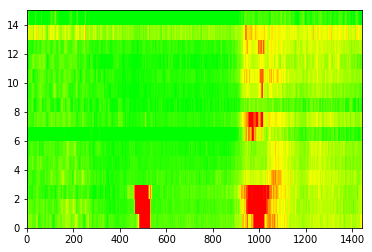

In [7]:
idx = 431  # test: [417,420,431]
print(data.loc[idx])

def vis_one_day_traffic_speed(speed):
    plt.pcolor(speed,cmap=my_cmap, vmin=20, vmax=70)
    
# vis_one_day_traffic_speed(db[257]['label'])
print(db[idx].keys())
print('db[idx]["weather"].shape: ',db[idx]['weather'].shape)
print('db[idx]["history"].shape: ',db[idx]['history'].shape)
print('db[idx]["label"].shape: ',db[idx]['label'].shape)
vis_one_day_traffic_speed(db[idx]['label']) 

In [8]:
def add_patch_dim_to_sample(sample):
    weather = sample['weather'].unsqueeze(0)
    label = sample['label'].unsqueeze(0)
    history = sample['history'].unsqueeze(0)
    sample = {'weather':weather,'label':label,'history':history}
    return sample

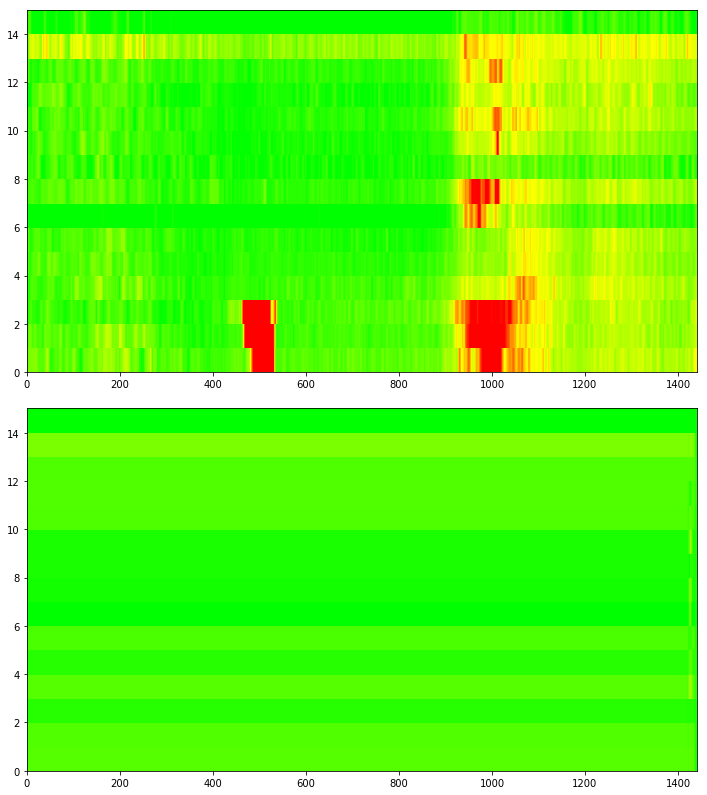

In [9]:
idx = 431  # test: [417,420,431]
out,label = model(add_patch_dim_to_sample(db[idx]))
out = out.data.cpu()[0]
label = label.data.cpu()[0]
gs = gridspec.GridSpec(2, 1, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=(12,14))
ax = plt.subplot(gs[0])
vis_one_day_traffic_speed(db[idx]['label'])
ax = plt.subplot(gs[1])
vis_one_day_traffic_speed(out) 